In [1]:
import numpy as np
import pandas as pd
import pandera as pa
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

mpl.style.use("fivethirtyeight")

# Initial Data Analysis

In [2]:
df = pd.read_csv("data/heart.csv")

In [3]:
df

,age,sex,chest pain type,resting blood pressure,chol,fasting blood sugar,resting ECG,max heart rate,exang,oldpeak,slope,number vessels flourosopy,thal,target
0,63,1,3,145,233,1,0,150.0,0,-99.99,0,0,1,1
1,37,1,2,130,250,0,1,187.0,0,3.50,0,0,2,1
2,41,0,1,130,204,0,0,NaN,0,1.40,2,0,2,1
3,56,1,1,120,236,0,1,178.0,0,0.80,2,0,2,1
4,57,0,0,120,354,0,1,163.0,1,0.60,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123.0,1,0.20,1,0,3,0
299,45,1,3,110,264,0,1,132.0,0,1.20,1,0,3,0
300,68,1,0,144,193,1,1,141.0,0,3.40,1,2,3,0
301,57,1,0,130,131,0,1,115.0,1,1.20,1,1,3,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        303 non-null    int64  
 1   sex                        303 non-null    int64  
 2   chest pain type            303 non-null    int64  
 3   resting blood pressure     303 non-null    int64  
 4   chol                       303 non-null    int64  
 5   fasting blood sugar        303 non-null    int64  
 6   resting ECG                303 non-null    int64  
 7   max heart rate             274 non-null    float64
 8   exang                      303 non-null    int64  
 9   oldpeak                    303 non-null    float64
 10  slope                      303 non-null    int64  
 11  number vessels flourosopy  303 non-null    int64  
 12  thal                       303 non-null    int64  
 13  target                     303 non-null    int64  

Only `max heart rate` has missing values.

Let's also check for duplicates.


In [5]:
print(f"Number of duplicates: {df.duplicated().sum()}")

Number of duplicates: 1


In [6]:
df[df.duplicated(keep=False)]

,age,sex,chest pain type,resting blood pressure,chol,fasting blood sugar,resting ECG,max heart rate,exang,oldpeak,slope,number vessels flourosopy,thal,target
163,38,1,2,138,175,0,1,173.0,0,0.0,2,4,2,1
164,38,1,2,138,175,0,1,173.0,0,0.0,2,4,2,1


For a quick summary of the data:


In [7]:
df.describe()

,age,sex,chest pain type,resting blood pressure,chol,fasting blood sugar,resting ECG,max heart rate,exang,oldpeak,slope,number vessels flourosopy,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,274.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.978102,0.326733,-6.617723,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.767327,0.469794,26.828542,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,-99.990000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,136.250000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.600000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.750000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


The `oldpeak` seems to have some outliers/anomalies. After a quick search online for this feature, it seems that it should only have values greater than 0.0.

Let's check how many values are less than 0.0 and they're distribution.


In [8]:
print(f"Number of negative values for oldpeak: {len(df[df["oldpeak"] < 0])}")

Number of negative values for oldpeak: 23


In [9]:
df[df["oldpeak"] < 0]["oldpeak"].value_counts()

oldpeak
-99.99    23
Name: count, dtype: int64

For now, will leave as is, but will keep in mind for later.

Looking at the catagorical features:


In [10]:
categorical_feats = [
    "sex",
    "chest pain type",
    "fasting blood sugar",
    "resting ECG",
    "exang",
    "number vessels flourosopy",
    "slope",
    "thal",
]
for column in categorical_feats:
    print(f"Column: {column}")
    print(df[column].value_counts())
    print()

Column: sex
sex
1    207
0     96
Name: count, dtype: int64

Column: chest pain type
chest pain type
0    143
2     87
1     50
3     23
Name: count, dtype: int64

Column: fasting blood sugar
fasting blood sugar
0    258
1     45
Name: count, dtype: int64

Column: resting ECG
resting ECG
1    152
0    147
2      4
Name: count, dtype: int64

Column: exang
exang
0    204
1     99
Name: count, dtype: int64

Column: number vessels flourosopy
number vessels flourosopy
0    175
1     65
2     38
3     20
4      5
Name: count, dtype: int64

Column: slope
slope
2    142
1    140
0     21
Name: count, dtype: int64

Column: thal
thal
2    166
3    117
1     18
0      2
Name: count, dtype: int64



Let's also check if the target value is balanced.


In [11]:
df["target"].value_counts(normalize=True)

target
1    0.544554
0    0.455446
Name: proportion, dtype: float64

Visualising the data:

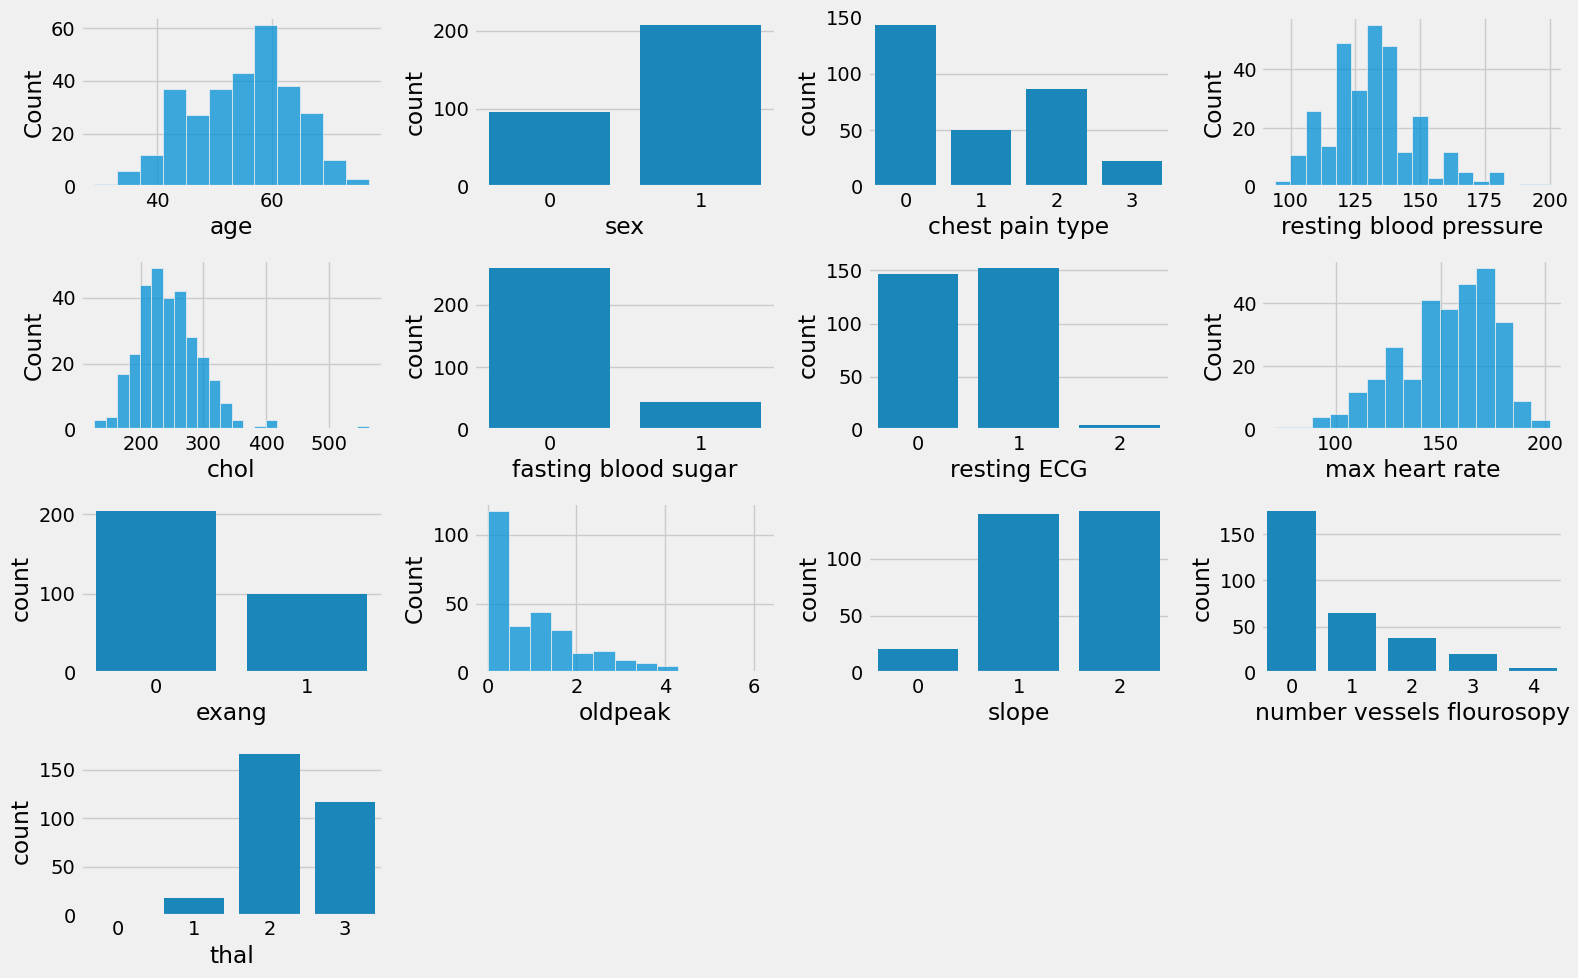

In [18]:
num_plots = len(df.columns) - 1  # Exclude the "target" column
num_rows = 4
num_cols = 4

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 10))

for i, col in enumerate(df.columns):
    if col != "target":
        ax = axes.flatten()[i]
        if col in categorical_feats:
            sns.countplot(data=df, x=col, ax=ax)
        elif col == "oldpeak":
            tmp_df = df[df["oldpeak"] >= 0]
            sns.histplot(data=tmp_df, x=col, ax=ax)
        else:
            sns.histplot(data=df, x=col, ax=ax)

# remove unused axes
for i in range(num_plots, len(axes.flatten())):
    fig.delaxes(axes.flatten()[i])

fig.tight_layout()

plt.show()

Visualising the data by the target value:

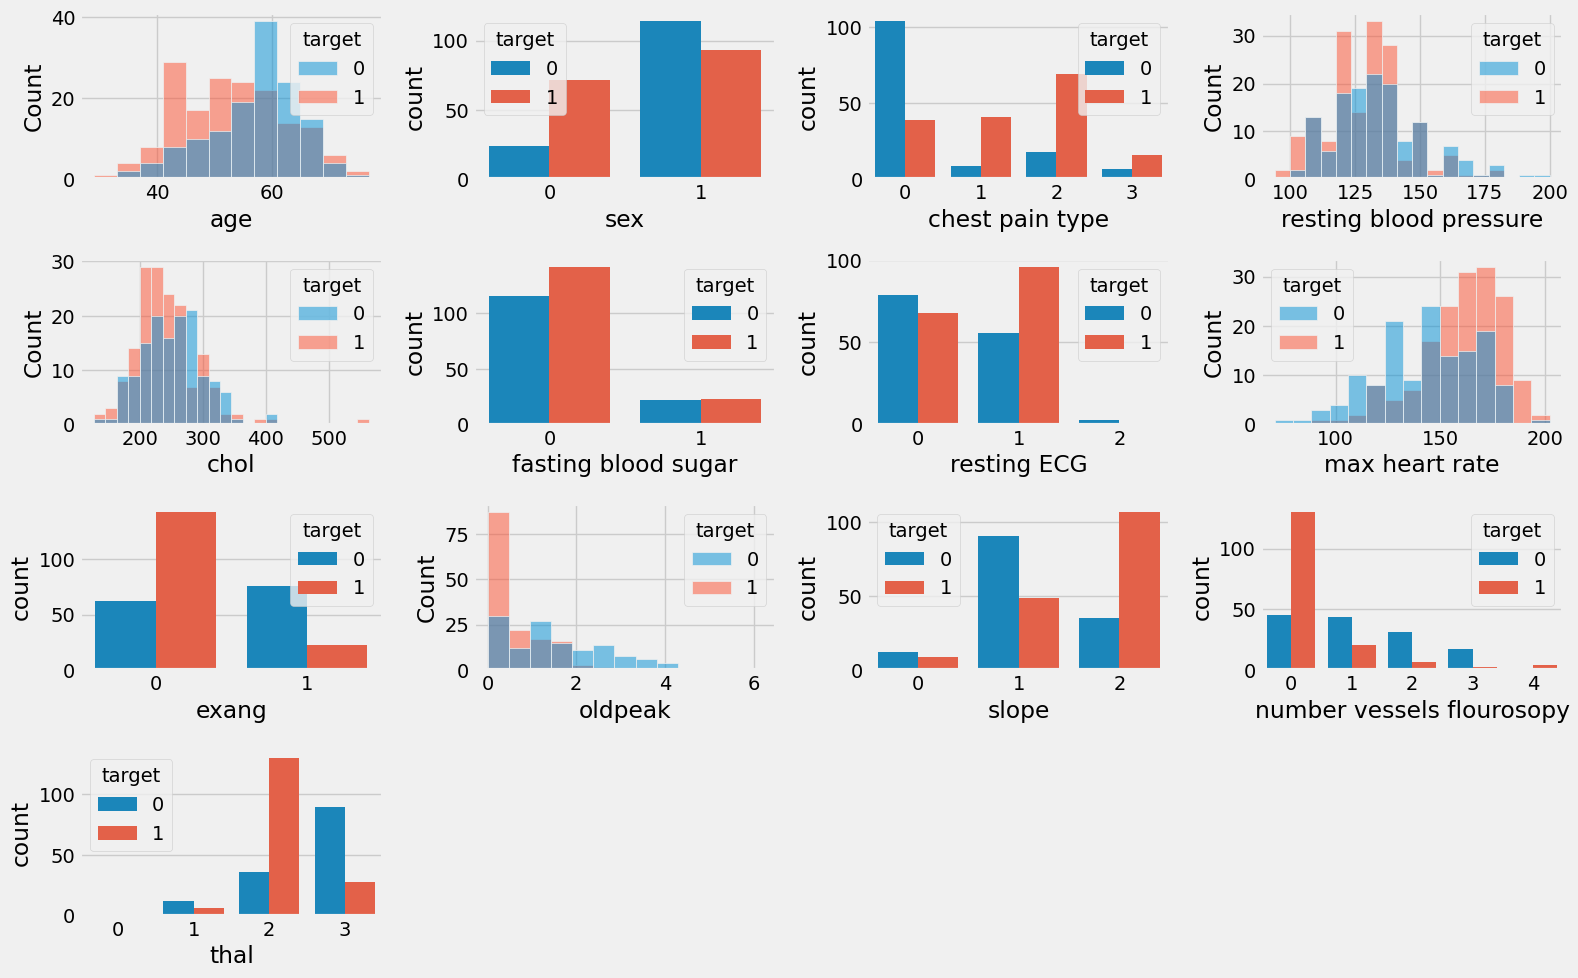

In [19]:
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 10))

for i, col in enumerate(df.columns):
    if col != "target":
        ax = axes.flatten()[i]
        if col in categorical_feats:
            sns.countplot(data=df, x=col, hue="target", ax=ax)
        elif col == "oldpeak":
            tmp_df = df[df["oldpeak"] >= 0]
            sns.histplot(data=tmp_df, x=col, hue="target", ax=ax)
        else:
            sns.histplot(data=df, x=col, hue="target", ax=ax)

# remove unused axes
for i in range(num_plots, len(axes.flatten())):
    fig.delaxes(axes.flatten()[i])

fig.tight_layout()

plt.show()

Quick look at the correlation between the features:

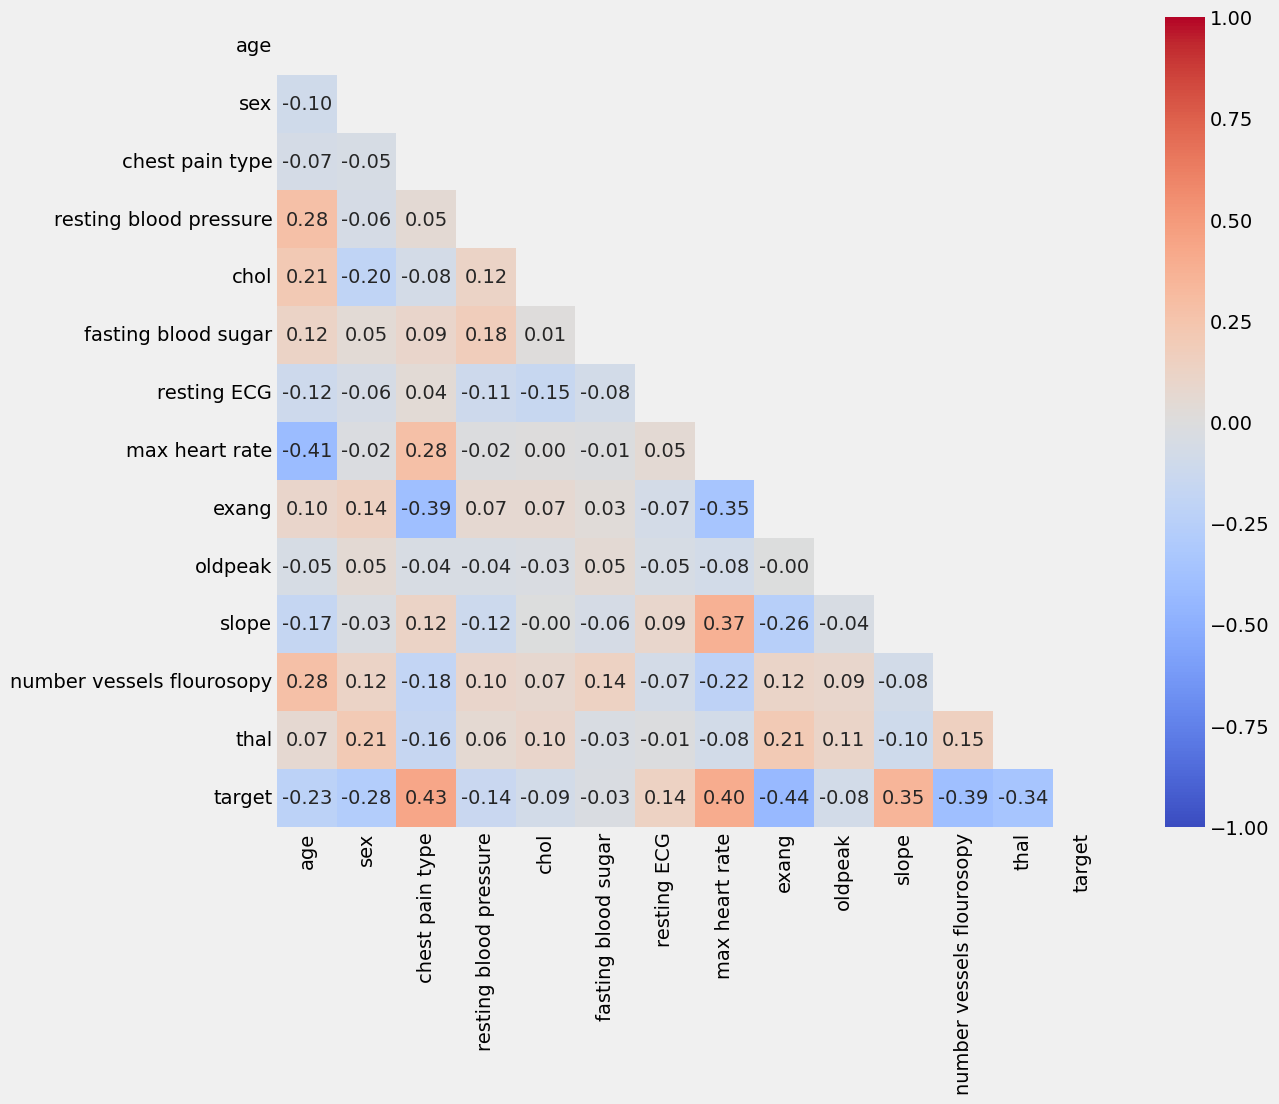

In [14]:
corr = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    mask=np.triu(corr),  # mask the upper triangle
    fmt=".2f",
)
plt.grid(False)
plt.show()

Let's look at the `max heart rate` feature as it has missing values. It may be possible to fill in the missing values based on the other features - as there is probably some existing paramterisations of this feature.

Using the second to last approximation from the following [source](https://onlinelibrary.wiley.com/doi/10.1111/j.1600-0838.2012.01445.x).

![Max heart rate equations](img/max_heart_rate_equations.png)


<Axes: xlabel='age', ylabel='max heart rate'>

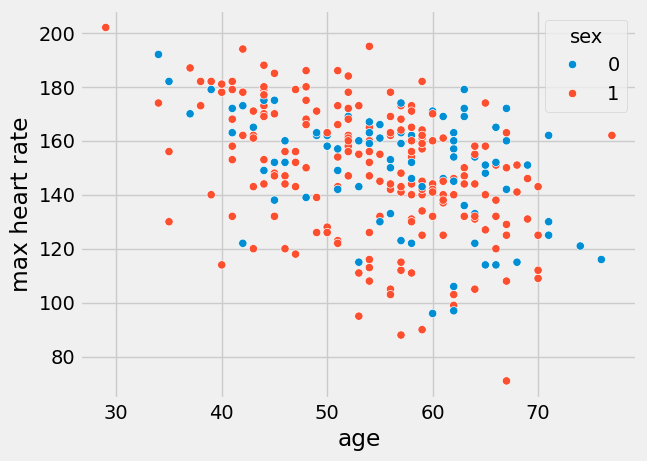

In [15]:
sns.scatterplot(data=df, x="age", y="max heart rate", hue="sex")

In [16]:
df["max heart rate"] = df["max heart rate"].fillna(211 - 0.64 * df["age"])

<Axes: xlabel='age', ylabel='max heart rate'>

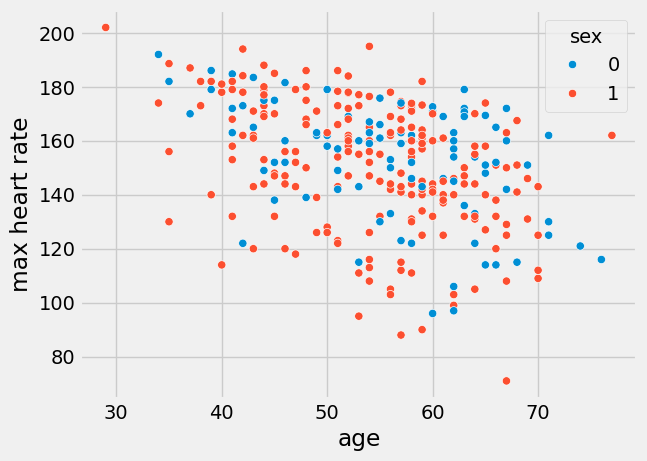

In [17]:
sns.scatterplot(data=df, x="age", y="max heart rate", hue="sex")

So, we could use this equation, however, this dataset is probably collected from a very different population than the one used in the study for this equation (patients with heart disease vs healthy sample). So, I will look at different ways to fill in the missing values later on.